# Homework 2

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

In [1]:
# PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from pyprojroot import here
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# SETTINGS
pd.set_option('display.float_format', '{:.4f}'.format) # Limiting floats output to 4 decimal points

# Set working directory
os.chdir("/Users/charleston/Downloads/git_repositories/finm-fixedincome-2025")

# DATE
quote_date = '2015-08-15'

# DATA
treasury_ts = pd.read_excel(here(f"./data/treasury_ts_{quote_date}.xlsx"), sheet_name="database")
treasury_ts.query('kytreasno in [204046, 204047]', inplace=True)
treasury_ts.set_index('caldt', inplace=True)

info = pd.read_excel(here(f"./data/treasury_ts_{quote_date}.xlsx"), sheet_name="info", skiprows=1)
info = info[['kytreasno', 204046, 204047]]


## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

In [2]:
# Extract relevant columns for the specified date
data_nov_4_2008 = treasury_ts.loc['2008-11-04']

# Create a new DataFrame for the chart
chart = pd.DataFrame({
    'Coupon Rate': info[info['kytreasno'] == 'tcouprt'].iloc[0, 1:].values[::-1], # In reverse order to match the chart
    'Bid': data_nov_4_2008['tdbid'].values,
    'Ask': data_nov_4_2008['tdask'].values,
    'Accrued Interest': data_nov_4_2008['tdaccint'].values,
    'Dirty Price': (data_nov_4_2008['tdbid'].values + data_nov_4_2008['tdask'].values) / 2 + data_nov_4_2008['tdaccint'].values,
    'Duration': (data_nov_4_2008['tdduratn']/365.25).values,
    'Modified Duration': ((data_nov_4_2008['tdduratn']/365.25)/(1+data_nov_4_2008['tdyld']*365.25/2)).values,
    'YTM': (data_nov_4_2008['tdyld']*365.25).values
}, index=['Notes', 'Bonds'])

# Display the chart DataFrame
chart.T

,Notes,Bonds
Coupon Rate,4.2500,10.6250
Bid,105.9531,141.8594
Ask,105.9844,141.8906
Accrued Interest,0.9355,2.3387
Dirty Price,106.9042,144.2137
Duration,5.9357,5.2301
Modified Duration,5.8412,5.1383
YTM,0.0324,0.0358


## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [3]:
hedge_ratio = pd.DataFrame(columns=['Equity', 'Assets', 'Contracts'], index=['Bonds', 'Notes'])

hedge_ratio.loc['Bonds', 'Equity'] = 1_000_000
hedge_ratio.loc['Bonds', 'Assets'] = 50_000_000
hedge_ratio.loc['Bonds', 'Contracts'] = hedge_ratio.loc['Bonds', 'Assets'] / chart.loc['Bonds', 'Dirty Price']

hedge_ratio.loc['Notes', 'Contracts'] = - hedge_ratio.loc['Bonds', 'Contracts'] * ((chart.loc['Bonds', 'Duration']*chart.loc['Bonds', 'Dirty Price'])/ (chart.loc['Notes', 'Duration']*chart.loc['Notes', 'Dirty Price']))
hedge_ratio.loc['Notes', 'Assets'] = hedge_ratio.loc['Notes', 'Contracts'] * chart.loc['Notes', 'Dirty Price']
hedge_ratio.loc['Notes', 'Equity'] = hedge_ratio.loc['Notes', 'Assets']/50

# Format the DataFrame
hedge_ratio_formatted = hedge_ratio.copy()
hedge_ratio_formatted['Equity'] = hedge_ratio_formatted['Equity'].apply(lambda x: f"${x:,.2f}")
hedge_ratio_formatted['Assets'] = hedge_ratio_formatted['Assets'].apply(lambda x: f"${x:,.2f}")
hedge_ratio_formatted['Contracts'] = hedge_ratio_formatted['Contracts'].apply(lambda x: f"{x:,.2f}")

# Display the formatted DataFrame
hedge_ratio_formatted

,Equity,Assets,Contracts
Bonds,"$1,000,000.00","$50,000,000.00","346,707.81"
Notes,"$-881,131.58","$-44,056,578.93","-412,112.66"


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 

In [4]:
# Modified duration is mathematically the elasticity of price with respect to the YTM. 
# The pnl that we would expect will be given by the modified duration, times the change in ytm, times the initial price.

profit_opportunity = pd.DataFrame(columns=['YTM Change', 'Modified Duration', 'Initial Price', 'Contracts', 'pnl'], index=['Bonds', 'Notes'])

profit_opportunity['YTM Change'] = [-0.00005, +0.00005]
profit_opportunity['Modified Duration'] = chart['Modified Duration']
profit_opportunity['Initial Price'] = chart['Dirty Price']
profit_opportunity['Contracts'] = hedge_ratio['Contracts'].astype(float)
profit_opportunity['pnl'] = -profit_opportunity['Modified Duration'] * profit_opportunity['YTM Change'] * profit_opportunity['Initial Price'] * profit_opportunity['Contracts']

total_profit = profit_opportunity['pnl'].sum()

# Display the DataFrame with formatted columns
profit_opportunity.style.format({
    'YTM Change': '{:.4%}',
    'Modified Duration': '{:.4f}',
    'Initial Price': '${:,.2f}',
    'Contracts': '{:,.2f}',
    'pnl': '${:,.2f}'
})

,YTM Change,Modified Duration,Initial Price,Contracts,pnl
Bonds,-0.0050%,5.1383,$144.21,"346,707.81","$12,845.71"
Notes,0.0050%,5.8412,$106.90,"-412,112.66","$12,867.14"


In [5]:
# Get the mid point of the YTM, and then get the change needed in YTM to converge to the mid point
converges = pd.DataFrame(columns=['YTM Change', 'Modified Duration', 'Initial Price', 'Contracts', 'pnl'], index=['Bonds', 'Notes'])

converges['YTM Change'] = ((chart['YTM'] - chart['YTM'].mean())).values
converges['Modified Duration'] = chart['Modified Duration']
converges['Initial Price'] = chart['Dirty Price']
converges['Contracts'] = hedge_ratio['Contracts'].astype(float)
converges['pnl'] = -converges['Modified Duration'] * converges['YTM Change'] * converges['Initial Price'] * converges['Contracts']

total_profit_converges = converges['pnl'].sum()

# Display the DataFrame with formatted columns
converges.style.format({
    'YTM Change': '{:.4%}',
    'Modified Duration': '{:.4f}',
    'Initial Price': '${:,.2f}',
    'Contracts': '{:,.2f}',
    'pnl': '${:,.2f}'
})

,YTM Change,Modified Duration,Initial Price,Contracts,pnl
Bonds,-0.1695%,5.1383,$144.21,"346,707.81","$435,509.58"
Notes,0.1695%,5.8412,$106.90,"-412,112.66","$436,236.08"


In [6]:
print(f"The net total profit and loss from the narrowing of spread is ${total_profit:,.2f}")
print(f"The net total profit and loss from the convergence is ${total_profit_converges:,.2f}")

The net total profit and loss from the narrowing of spread is $25,712.85
The net total profit and loss from the convergence is $871,745.67


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

In [7]:
start_date = '2008-11-04'
end_date = '2008-12-16'

# Calculate dirty prices for the specified dates
treasury_ts['dirty_price'] = (treasury_ts['tdbid'] + treasury_ts['tdask']) / 2 + treasury_ts['tdaccint']
dirty_prices = treasury_ts.pivot_table(index='caldt', columns='kytreasno', values='dirty_price')

# Initialize a DataFrame to store the values and price changes
values = pd.DataFrame(index=dirty_prices.index, columns=['Value', 'Price Change', 'YTM Spread (bps)'])

# Set the initial dirty prices and contracts
initial_dirty_prices = dirty_prices.loc[start_date].values
contracts = hedge_ratio['Contracts'].astype(float).values

# Calculate the value of the position for each date
values['Value'] = (dirty_prices.values * contracts).sum(axis=1)
values['Price Change'] = values['Value'] - values['Value'].loc[start_date]

# Calculate YTM spread in basis points with respect to the mean value of their YTM
ytm_spread = (treasury_ts.query('kytreasno == 204046')['tdyld'] - treasury_ts.query('kytreasno == 204047')['tdyld']) * 10000
values['YTM Spread (bps)'] = ytm_spread.values

# Format the values with commas and $ signs
values_formatted = values.copy()
values_formatted['Value'] = values_formatted['Value'].apply(lambda x: f"${x:,.2f}")
values_formatted['Price Change'] = values_formatted['Price Change'].apply(lambda x: f"${x:,.2f}")
values_formatted['YTM Spread (bps)'] = values_formatted['YTM Spread (bps)'].apply(lambda x: f"{x:.2%}")

values_formatted.loc[[start_date, '2008-11-25', end_date]]

,Value,Price Change,YTM Spread (bps)
caldt,,,
2008-11-04,"$5,943,421.07",$0.00,9.28%
2008-11-25,"$5,444,348.25","$-499,072.82",14.51%
2008-12-16,"$4,894,088.32","$-1,049,332.75",19.62%


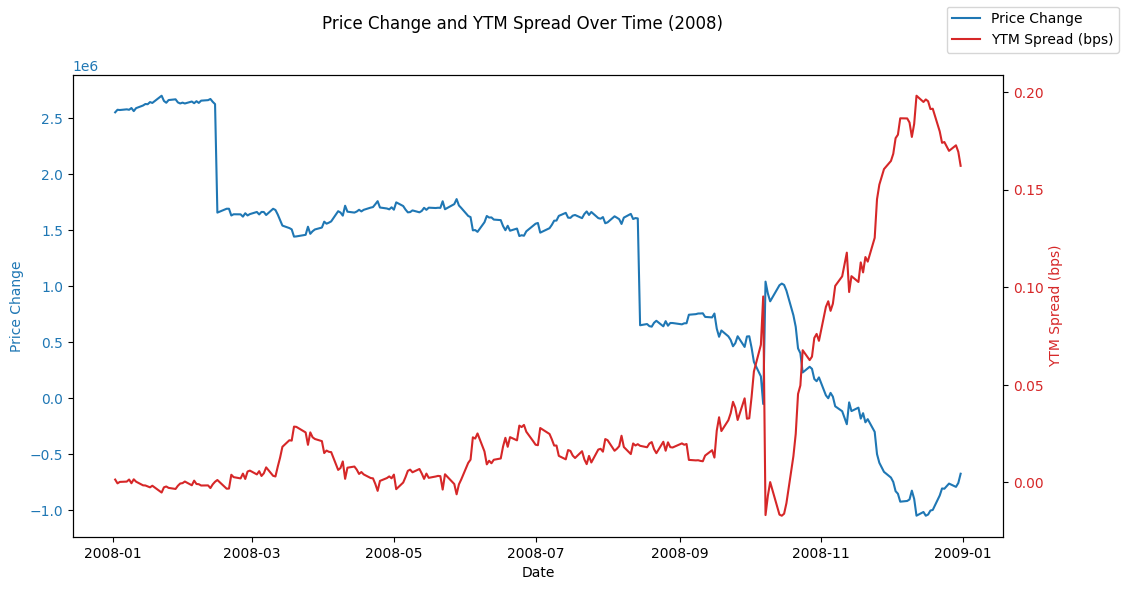

In [8]:
# Filter the values DataFrame to include only dates within 2008
values_2008 = values.loc['2008']

# Plot the Price Change and YTM Spread for 2008
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Price Change
ax1.set_xlabel('Date')
ax1.set_ylabel('Price Change', color='tab:blue')
ax1.plot(values_2008.index, values_2008['Price Change'], color='tab:blue', label='Price Change')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot the YTM Spread
ax2 = ax1.twinx()
ax2.set_ylabel('YTM Spread (bps)', color='tab:red')
ax2.plot(values_2008.index, values_2008['YTM Spread (bps)'], color='tab:red', label='YTM Spread (bps)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and legend
fig.suptitle('Price Change and YTM Spread Over Time (2008)')
fig.legend(loc='upper right')

# Show the plot
plt.show()


## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

In [9]:
values_formatted.loc[['2009-01-27', '2009-03-24', '2009-06-16']]

,Value,Price Change,YTM Spread (bps)
caldt,,,
2009-01-27,"$5,964,078.43","$20,657.36",9.68%
2009-03-24,"$5,397,912.84","$-545,508.23",6.03%
2009-06-16,"$6,177,585.98","$234,164.91",-1.95%


### Answer
1. The results for 2008. It is a good approximation, but it does not work great with higher differences in duration.
2. The results for 2009. During the first six months the spread converged to zero, resulting in a positive pnl. The estimation of PNL using duration and spread seems accurate. 

***

# 2 Hedging Duration

Use data from `../data/treasury_ts_duration_2024-10-31.xlsx`.

The file contains time-series information on two treasuries. Observe the info of the securities with the following code:


In [10]:
QUOTE_DATE = '2024-10-31'

data = pd.read_excel(here(f"./data/treasury_ts_duration_{QUOTE_DATE}.xlsx"),sheet_name='database')
data_info =  data.drop_duplicates(subset='KYTREASNO', keep='first').set_index('KYTREASNO')
data_info[['type','issue date','maturity date','cpn rate']]

,type,issue date,maturity date,cpn rate
KYTREASNO,,,,
207391,note,2019-08-15,2029-08-15,1.6250
207392,bond,2019-08-15,2049-08-15,2.2500


You will largely focus on the sheets which give the timeseries of prices and durations for each of the two securities, as shown in the following code.

In [11]:
SHEET_PRICE = 'price'
SHEET_DURATION = 'duration'
INDEX_NAME = 'quote date'

price = pd.read_excel(here(f"./data/treasury_ts_duration_{QUOTE_DATE}.xlsx"),sheet_name=SHEET_PRICE).set_index(INDEX_NAME)
duration = pd.read_excel(here(f"./data/treasury_ts_duration_{QUOTE_DATE}.xlsx"),sheet_name=SHEET_DURATION).set_index(INDEX_NAME)

display(price)
display(duration)

,207391,207392
quote date,,
2019-08-09,98.8828,99.7891
2019-08-12,99.7969,102.5547
2019-08-13,99.2812,101.8672
2019-08-14,100.4062,105.1797
2019-08-15,100.8828,106.2344
...,...,...
2024-11-22,88.7402,63.7227
2024-11-25,89.2871,65.3789
2024-11-26,89.2148,65.1758


,207391,207392
quote date,,
2019-08-09,9.2895,22.0001
2019-08-12,9.2855,22.1185
2019-08-13,9.2803,22.0843
2019-08-14,9.2828,22.2285
2019-08-15,9.2822,22.2709
...,...,...
2024-11-22,4.5394,17.2055
2024-11-25,4.5320,17.3123
2024-11-26,4.5291,17.2955


### 2.1.

Suppose you have a portfolio of `10,000` USD long in security `207391` on the first day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

In [12]:
# PARAMETERS
size = 10_000
id_long = 207391
id_short = 207392

hedged_position = pd.DataFrame(index=price.index, columns=['Long', 'Short', 'Hedge Ratio'])
hedged_position['Long'] = size/price[id_long]
hedged_position['Short'] = - hedged_position['Long'] * (duration[id_long]*price[id_long]) / (duration[id_short]*price[id_short])
hedged_position['Hedge Ratio'] = (duration[id_long]/duration[id_short]) * price[id_long] / price[id_short]
hedged_position['Long ($)'] = hedged_position['Long'] * price[id_long]
hedged_position['Short ($)'] = hedged_position['Short'] * price[id_short]
hedged_position['Net ($)'] = hedged_position[['Long ($)','Short ($)']].sum(axis=1)

hedged_position[:1]

,Long,Short,Hedge Ratio,Long ($),Short ($),Net ($)
quote date,,,,,,
2019-08-09,101.1298,-42.3140,0.4184,10000.0000,-4222.4791,5777.5209


In [13]:
# Check if the position is hedged
wts = hedged_position[['Long ($)','Short ($)']].div(hedged_position[['Long ($)','Short ($)']].sum(axis=1),axis=0) # weights. Position by long/short divided between the sum of both positions
hedged_position['duration'] = (wts * duration[[id_long,id_short]].values).sum(axis=1)
hedged_position['duration'].describe().to_frame().T.style.format('{:.1%}')


,count,mean,std,min,25%,50%,75%,max
duration,133000.0%,0.0%,0.0%,-0.0%,-0.0%,0.0%,0.0%,0.0%


### 2.2.

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be `10,000`.
* Repeat throughout the timeseries.

Calculate the daily profit and loss (PnL) for the
* dynamically hedged position constructed above.
* long-only position, (still at `10,000` throughout.)

(You might check to verify that the net duration is zero at all dates.)

Report...
* the cumulative PnL of both strategies via a plot.
* the (daily) mean, standard deviation, min, and max of the PnL in a table.

In [14]:
hedged_position[['Long ($) realized', 'Short ($) realized']] = hedged_position[['Long', 'Short']]*price.shift(-1).values
hedged_position[['Long pnl', 'Short pnl']] = hedged_position[['Long ($) realized', 'Short ($) realized']] - hedged_position[['Long ($)', 'Short ($)']].values
hedged_position['Net pnl'] = hedged_position['Long pnl'] + hedged_position['Short pnl']
hedged_position['Net pnl long'] = price[id_long].diff()*hedged_position['Long'].shift()
hedged_position[['Net pnl','Net pnl long']].describe().drop(index=['count']).style.format('${:,.2f}')


,Net pnl,Net pnl long
mean,$0.06,$-0.63
std,$21.09,$44.59
min,$-98.34,$-321.20
25%,$-11.02,$-26.68
50%,$0.00,$-1.46
75%,$10.41,$24.57
max,$118.43,$276.27


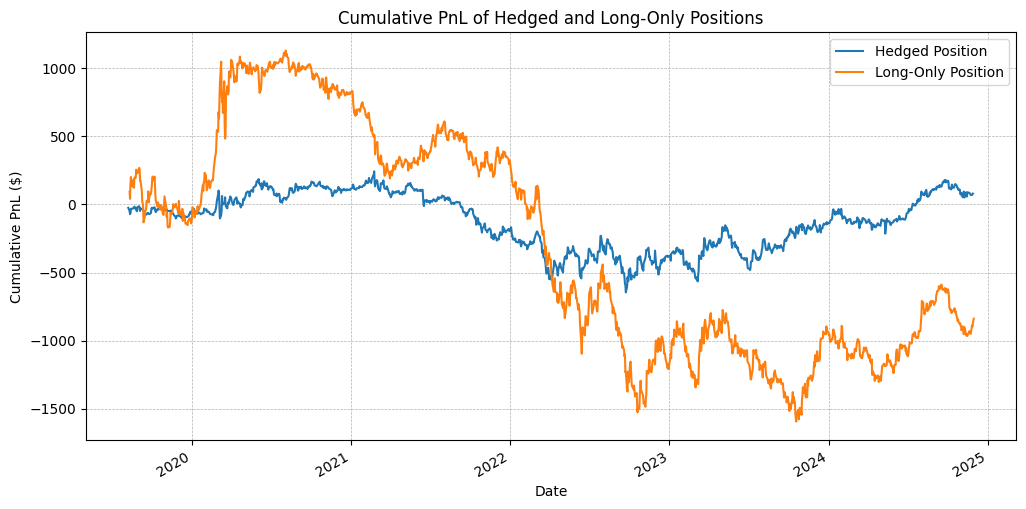

In [15]:
# Plot the cumulative PnL for both strategies
fig, ax = plt.subplots(figsize=(12, 6))

hedged_position[['Net pnl', 'Net pnl long']].cumsum().plot(ax=ax)

# Set titles and labels
ax.set_title('Cumulative PnL of Hedged and Long-Only Positions')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative PnL ($)')

# Add gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend
ax.legend(['Hedged Position', 'Long-Only Position'])

# Show the plot
plt.show()

### 2.3.

Give two reasons that the daily PnL is not always zero for the hedged position given that we have perfectly hedged the duration.

### Answer

There are other factors that influence bond prices beyond duration. Duration assumes changes a linear change between price and interest rates. 

1. Convexity: The 30-year bond will have higher convexity compared to the 10-year note. Convexity tells us how the price sensitivity to interest rate changes varies across the two instruments. Higher convexity means the 30-year bond's price will increase more (or decrease less) than the 10-year note when interest rates fall (or rise), even if their durations are perfectly hedged.

2. Coupon rate: The 30-year bond has a higher coupon (2.25) compared to the 10-year note. The difference in cash flow structures can result in inconsistent yield sensitivities during periods of changing interest rates or changes in the yield curve shape. 

### 2.4.
The PnL above doesn't account for the coupons.

Calculate a dataframe indexed by dates with columns for the two treasuries with values of coupon payments. 
* Recall that the stated coupon rate is semiannual, so at any give coupon date, it pays half the stated rate.
* Figure out the coupon dates by using the `data` tab and looking for dates where `acc int` goes down. Recall that accrued interest measures the portion of the coupon period that has passed. So when this resets, it is because the coupon has been paid.

Report the first 5 dates that a coupon is paid (by either bond).

In [16]:
data.sort_values(by = ['KYTREASNO', 'quote date'], inplace=True)
accrued_int = data.pivot_table(index='quote date', columns='KYTREASNO', values='accrued int')

coupon_dates = accrued_int.diff().apply(lambda x: x < 0).any(axis=1)
coupon_dates = coupon_dates[coupon_dates == True]
coupon_dates.iloc[:5]


quote date
2020-02-18    True
2020-08-17    True
2021-02-16    True
2021-08-16    True
2022-02-15    True
dtype: bool


### 2.5.
Account for the coupons in the PnL calculations of `2.2`. Report the updated PnL in a plot and a table, similar to the reporting in `2.2`.

In [20]:
hedged_position['Coupon Long'] = 0
hedged_position['Coupon Short'] = 0

hedged_position.loc[coupon_dates.index, 'Coupon Long'] = data_info.loc[id_long, 'cpn rate']/2
hedged_position.loc[coupon_dates.index, 'Coupon Short'] = data_info.loc[id_short, 'cpn rate']/2

hedged_position['Coupon pnl'] = (hedged_position['Coupon Long'] * hedged_position['Long'].shift()) + (hedged_position['Coupon Short'] * hedged_position['Short'].shift())

hedged_position['Total pnl'] = hedged_position['Net pnl'] + hedged_position['Coupon pnl']

hedged_position[['Net pnl', 'Coupon pnl', 'Total pnl']].describe().drop(index=['count']).style.format('${:,.2f}')

,Net pnl,Coupon pnl,Total pnl
mean,$0.06,$0.31,$0.39
std,$21.09,$3.57,$21.35
min,$-98.34,$0.00,$-98.34
25%,$-11.02,$0.00,$-10.76
50%,$0.00,$0.00,$0.00
75%,$10.41,$0.00,$10.95
max,$118.43,$45.32,$118.43


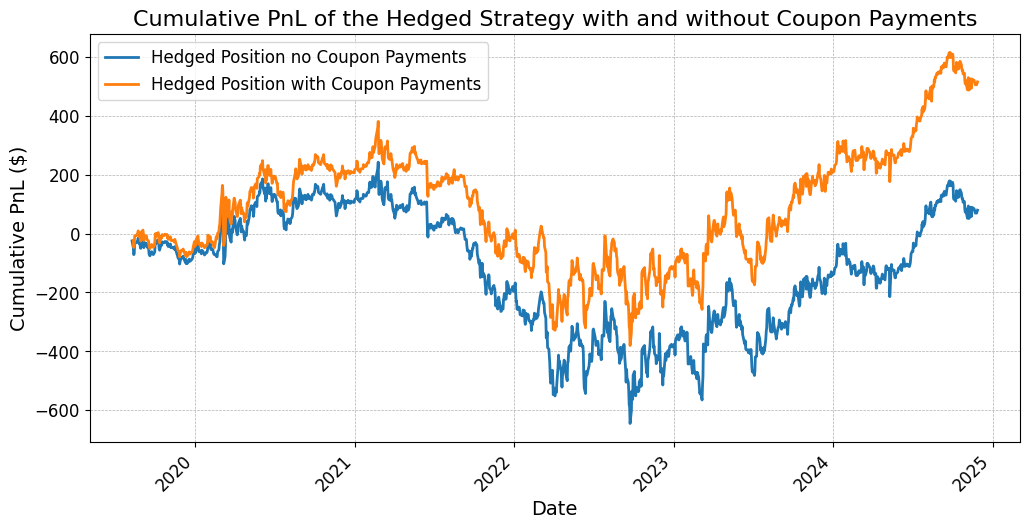

In [19]:
# Plot the cumulative PnL for both strategies
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative PnL
hedged_position[['Net pnl', 'Total pnl']].cumsum().plot(ax=ax, linewidth=2)

# Set titles and labels
ax.set_title('Cumulative PnL of the Hedged Strategy with and without Coupon Payments', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Cumulative PnL ($)', fontsize=14)

# Add gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend
ax.legend(['Hedged Position no Coupon Payments', 'Hedged Position with Coupon Payments'], fontsize=12)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

***